# Parse Microsoft Mined Road as GPKG

[Microsoft's RoadDetection Github](https://github.com/microsoft/RoadDetections) repo contain road network extracted using deep learning methods from satellite imagery. The data is a TSV format, which requires further processing. This script convert given url containing zip file from Microsoft's Github repository, subsequently convert them to Geopackage for easier processing and visualization in QGIS.

## Preparation

Setup libraries and the url. Change the url accordingly (get them from the repo: https://github.com/microsoft/RoadDetections)

In [2]:
!pip install geopandas --quiet

**Change the URL** below based on regions from the repo above.

In [3]:
# Change the URL here

url = 'https://usaminedroads.blob.core.windows.net/road-detections/AsiaSouthEast-Full.zip'

In [4]:
# extract filename from link above
filename = url.split('/')[4]
filename = filename.split('.')[0] + '.tsv'

print(filename)

AsiaSouthEast-Full.tsv


## Extract Data on Selected Country

Download file the from URL above, extract zip file, convert them to pandas dataframe

In [3]:
# Download the data
import requests
import zipfile

# Download the ZIP file
response = requests.get(url)

# Save the ZIP file to a local file
open("file.zip", "wb").write(response.content)

# Open the ZIP file
zip_ref = zipfile.ZipFile("file.zip", "r")

# Extract the contents of the ZIP file to the current directory
zip_ref.extractall()

# Close the ZIP file
zip_ref.close()

Convert the extracted TSV file to pandas Dataframe. If the dataset is too large, use Dask instead of Pandas

In [5]:
import pandas as pd

# Read the TSV file
df = pd.read_csv(filename, sep="\t", names=["country_id", "geometry"], header=None)

# Print the first 5 rows of the DataFrame
print(df.head())


  country_id                                               geom
0        IDN  {"type":"Feature","geometry":{"type":"LineStri...
1        IDN  {"type":"Feature","geometry":{"type":"LineStri...
2        IDN  {"type":"Feature","geometry":{"type":"LineStri...
3        IDN  {"type":"Feature","geometry":{"type":"LineStri...
4        IDN  {"type":"Feature","geometry":{"type":"LineStri...


List all the country codes from the file. Link for reference: https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3

In [10]:
# list country code from the downloaded file
list_of_countries = df["country_id"].unique()
print("List of Countries: \r\n", list_of_countries)

# Number of extracted road segments per country
data_per_country = df["country_id"].value_counts()
print("\r\nData per Country:\r\n", data_per_country)

List of Countries: 
 ['IDN' 'TWN' 'BRN' 'KHM' 'TLS' 'MYS' 'LAO' 'PHL' 'MMR' 'SGP' 'VNM' 'THA']

Data per Country:
 IDN    4027800
THA    2296891
MYS    1343149
VNM    1252233
PHL    1081034
MMR     840823
TWN     528394
KHM     260713
LAO     150289
SGP      32656
BRN      23146
TLS      10113
Name: country_id, dtype: int64


**Change the selected country** below based on the country code. 

In [11]:
# change selected country accordingly
selected_country = 'IDN'

In [12]:
# Slice the dataframe
selected_data = df.loc[df["country_id"] == selected_country, :]
print(len(selected_data))
print(selected_data.head())

4027800
  country_id                                               geom
0        IDN  {"type":"Feature","geometry":{"type":"LineStri...
1        IDN  {"type":"Feature","geometry":{"type":"LineStri...
2        IDN  {"type":"Feature","geometry":{"type":"LineStri...
3        IDN  {"type":"Feature","geometry":{"type":"LineStri...
4        IDN  {"type":"Feature","geometry":{"type":"LineStri...


## Processing 

Extract geometry from Pandas, convert the geometry to geopandas dataframe and save the resulting GPKG

In [13]:
import geopandas as gpd
import pandas as pd
import json
from shapely.geometry import shape

In [14]:
# define function for parsing 

def parse_geom(geom_str):
    try:
        return shape(json.loads(geom_str)["geometry"])
    except:  # Handle NaN and empty strings
        return None

In [15]:
# Convert the column to shapely WKT geometry
# take some time to process
%%timeit
selected_data["geometry"] = selected_data["geometry"].apply(parse_geom)


<ipython-input-15-483a50f030d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data["geometry"] = selected_data["geom"].apply(parse_geom)


In [16]:
# display the selected data
selected_data.head()

,country_id,geom,geometry
0,IDN,"{""type"":""Feature"",""geometry"":{""type"":""LineStri...",LINESTRING (111.811240911484 -8.14734736361994...
1,IDN,"{""type"":""Feature"",""geometry"":{""type"":""LineStri...",LINESTRING (112.001624107361 -7.80413737086135...
2,IDN,"{""type"":""Feature"",""geometry"":{""type"":""LineStri...",LINESTRING (102.287263870239 -3.80573141046796...
3,IDN,"{""type"":""Feature"",""geometry"":{""type"":""LineStri...",LINESTRING (102.638783454895 -2.30605543771412...
4,IDN,"{""type"":""Feature"",""geometry"":{""type"":""LineStri...",LINESTRING (101.406909227371 0.516404074379437...


In [17]:
# make a geodataframe out of the converted geometry
gdf = gpd.GeoDataFrame(selected_data, geometry="geometry")
print(gdf.head())

  country_id                                               geom  \
0        IDN  {"type":"Feature","geometry":{"type":"LineStri...   
1        IDN  {"type":"Feature","geometry":{"type":"LineStri...   
2        IDN  {"type":"Feature","geometry":{"type":"LineStri...   
3        IDN  {"type":"Feature","geometry":{"type":"LineStri...   
4        IDN  {"type":"Feature","geometry":{"type":"LineStri...   

                                            geometry  
0  LINESTRING (111.81124 -8.14735, 111.81163 -8.1...  
1  LINESTRING (112.00162 -7.80414, 112.00127 -7.8...  
2  LINESTRING (102.28726 -3.80573, 102.28734 -3.8...  
3  LINESTRING (102.63878 -2.30606, 102.64088 -2.3...  
4  LINESTRING (101.40691 0.51640, 101.40614 0.516...  


(92.7301030755043, 143.3660776019097, -11.777370984239026, 6.747422083670093)

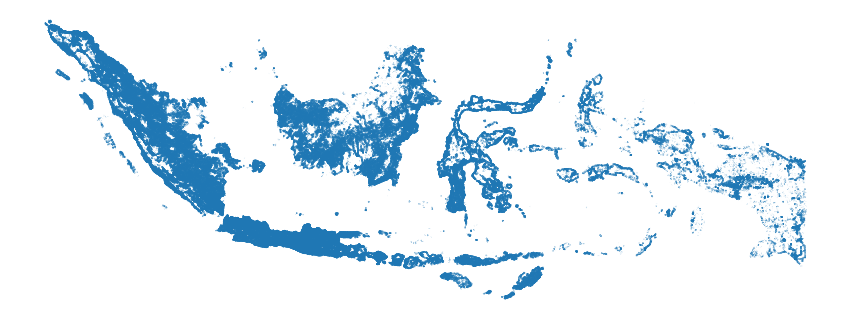

In [19]:
# Plot the data
ax = gdf.plot(figsize=(15, 15))
ax.axis('off')

In [24]:
# export to gpkg
gdf.to_file(selected_country+".gpkg", driver="GPKG")

In [25]:
# download the GPKG file
from google.colab import files
files.download(selected_country+".gpkg") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>